This runs all segmentation operations in one place.
The idea is that this should be faster and easier to envoke as we only have to load the image data once instead of N times (~10).
Running each individual task as its own script is modular but requires overhead to load the data each time.
Currently it takes about 15 minutes to complete a single organoid's segmentation for all compartments... (~50,1500,1500) (Z,Y,X) dimensional image. 
Let us see how long this takes!

No we are at ~8 minutes!

In [1]:
import argparse
import json
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from organoid_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-1"
    clip_limit = 0.01
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [5]:
# look up the morphology of the organoid from json file
image_label_path = pathlib.Path(
    "../image_labels/organoid_image_labels.parquet"
).resolve(strict=True)
organoid_image_labels_df = pd.read_parquet(image_label_path)
# look up the morphology for this well_fov
morphology = organoid_image_labels_df.loc[
    organoid_image_labels_df["well_fov"] == well_fov, "label"
].values[0]
print(f"Organoid morphology for {well_fov}: {morphology}")

Organoid morphology for C4-1: globular


In [6]:
return_dict = read_in_channels(
    find_files_available(input_dir),
    channel_dict={
        "nuclei": "405",
        "cyto1": "488",
        "cyto2": "555",
        "cyto3": "640",
        "brightfield": "TRANS",
    },
    channels_to_read=["cyto2"],
)
cyto2_raw = return_dict["cyto2"]
del return_dict
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
nuclei_mask = read_zstack_image(nuclei_mask_output)
# run clip_limit here
cyto2 = skimage.exposure.equalize_adapthist(
    cyto2_raw, clip_limit=clip_limit, kernel_size=None
)
del cyto2_raw

## Segment the cells

In [ ]:
def segment_cells_with_3D_watershed(
    cyto_signal: np.ndarray,
    nuclei_mask: np.ndarray,
) -> np.ndarray:
    """ "
    Description
    -----------
        Segments cells using 3D watershed algorithm given cytoplasm signal and nuclei mask.
    Parameters
    ----------
        cyto_signal : np.ndarray
            3D numpy array representing the cytoplasm signal.
        nuclei_mask : np.ndarray
            3D numpy array representing the nuclei mask.
    Returns
    -------
        np.ndarray
            3D numpy array representing the segmented cell mask.
    """
    labels = skimage.segmentation.watershed(
        image=cyto_signal,
        markers=nuclei_mask,
        connectivity=1,
        compactness=0,
    )

    # change the largest label (by area) to 0
    # cleans up the output and sets the background properly
    unique, counts = np.unique(labels, return_counts=True)
    largest_label = unique[np.argmax(counts)]
    labels[labels == largest_label] = 0
    return labels


def perform_morphology_dependent_segmentation(
    label: str,
    cyto2: np.ndarray,
    nuclei_mask: np.ndarray,
) -> np.ndarray:
    """
    Description
    -----------
        Performs morphology dependent segmentation based on the provided morphology label.
    Parameters
    ----------
        label : str
            Morphology label indicating the type of morphology.
        cyto2 : np.ndarray
            3D numpy array representing the cytoplasm signal.
        nuclei_mask : np.ndarray
            3D numpy array representing the nuclei mask.
    Returns
    -------
        np.ndarray
            3D numpy array representing the segmented cell mask.
    """
    # generate the low frequency elevation map
    # all morhology types use the same initial elevation map
    elevation_map = skimage.filters.butterworth(
        cyto2,
        cutoff_frequency_ratio=0.08,
        order=2,
        high_pass=False,
        squared_butterworth=False,
    )
    # generate threshold using otsu
    threshold = skimage.filters.threshold_otsu(elevation_map)
    # generate thresholded signal
    elevation_map_threshold_signal = elevation_map.copy()
    elevation_map_threshold_signal = elevation_map_threshold_signal > threshold

    nuclei_mask = skimage.measure.label(nuclei_mask > 0)

    min_size = 100  # volume in voxels
    max_size = 10_000_000  # volume in voxels

    if label == "globular":
        elevation_map = skimage.filters.gaussian(elevation_map, sigma=1.0)
        elevation_map = sobel(elevation_map)

    elif label == "dissociated":
        print("Dissociated morphology selected")
        elevation_map = skimage.morphology.binary_dilation(
            elevation_map_threshold_signal,
            skimage.morphology.ball(2),
        )
        elevation_map = sobel(elevation_map)
        elevation_map = skimage.filters.gaussian(elevation_map, sigma=3)
        nuclei_mask = skimage.morphology.erosion(
            nuclei_mask > 0, skimage.morphology.ball(1)
        )
        nuclei_mask = skimage.measure.label(nuclei_mask)
    elif label == "small":
        elevation_map = sobel(elevation_map)
        elevation_map = skimage.filters.gaussian(elevation_map, sigma=3)
    elif label == "elongated":
        elevation_map = sobel(elevation_map_threshold_signal)
        elevation_map = skimage.filters.gaussian(elevation_map, sigma=3)
        nuclei_mask = skimage.morphology.erosion(
            nuclei_mask > 0, skimage.morphology.ball(1)
        )
        nuclei_mask = skimage.measure.label(nuclei_mask)
    else:
        raise ValueError(f"Unknown morphology label: {label}")

    cell_mask = segment_cells_with_3D_watershed(
        cyto_signal=elevation_map,
        nuclei_mask=nuclei_mask,
    )
    # remove small objects
    cell_mask = skimage.morphology.remove_small_objects(
        cell_mask,
        min_size=min_size,
    )
    # remove large objects
    unique, counts = np.unique(cell_mask[cell_mask > 0], return_counts=True)
    for label, count in zip(unique, counts):
        if count > max_size:
            cell_mask[cell_mask == label] = 0

    return cell_mask

In [26]:
cell_mask = perform_morphology_dependent_segmentation(
    morphology,
    cyto2,
    nuclei_mask,
)

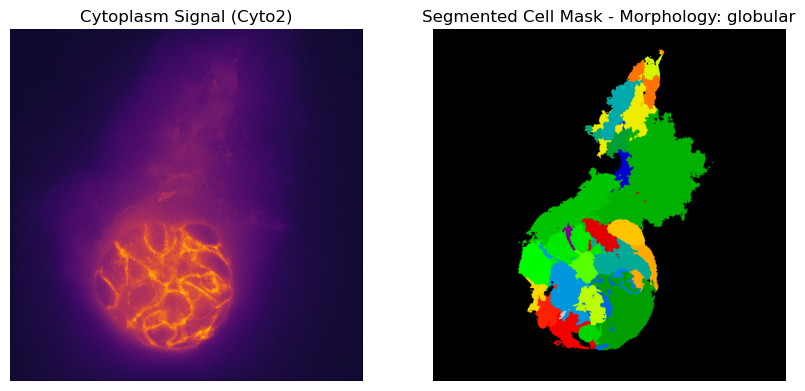

In [ ]:
if in_notebook:
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(cyto2[cyto2.shape[0] // 2], cmap="inferno")
    plt.title("Cytoplasm Signal (Cyto2)")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(cell_mask[cell_mask.shape[0] // 2], cmap="nipy_spectral")
    plt.title(f"Segmented Cell Mask - Morphology: {morphology}")
    plt.axis("off")
    plt.show()

## run the mask reassignment function (post-hoc)
### This needs to occur after both nuclei and cell segmentations are done

In [29]:
cell_df = get_labels_for_post_hoc_reassignment(
    compartment_mask=cell_mask, compartment_name="cell"
)
nuclei_df = get_labels_for_post_hoc_reassignment(
    compartment_mask=nuclei_mask, compartment_name="nuclei"
)

In [30]:
nuclei_mask, reassigned_nuclei_df = run_post_hoc_mask_reassignment(
    nuclei_mask=nuclei_mask,
    cell_mask=cell_mask,
    nuclei_df=nuclei_df,
    cell_df=cell_df,
    return_dataframe=True,
)

In [31]:
# refine the nuclei masks
cell_mask = run_post_hoc_refinement(
    mask_image=cell_mask,
    sliding_window_context=3,
)

## Cytoplasm Segmentation

In [32]:
cytoplasm_mask = create_cytoplasm_masks(
    nuclei_masks=nuclei_mask,
    cell_masks=cell_mask,
)

## Organoid segmentation (derived from cell segmentation)

In [33]:
# convert the cell masks to binary masks
cell_binary_mask = cell_mask.copy()
cell_binary_mask[cell_binary_mask > 0] = 1
# dilate the cell masks slightly
cell_binary_mask = skimage.morphology.binary_dilation(
    cell_binary_mask, skimage.morphology.ball(10)
)
# convert back to instance mask
# make sure each instance has a unique integer label
organoid_mask = skimage.measure.label(cell_binary_mask)

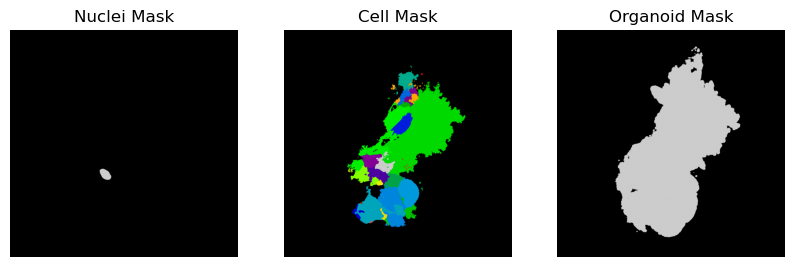

In [34]:
if in_notebook:
    z = 8
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.title("Nuclei Mask")
    plt.imshow(nuclei_mask[z, :, :], cmap="nipy_spectral")
    plt.axis("off")
    plt.subplot(132)
    plt.title("Cell Mask")
    plt.imshow(cell_mask[z, :, :], cmap="nipy_spectral")
    plt.axis("off")
    plt.subplot(133)
    plt.title("Organoid Mask")
    plt.imshow(organoid_mask[z, :, :], cmap="nipy_spectral")
    plt.axis("off")
    plt.show()

## Save the segmented masks

In [35]:
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
cell_mask_output = pathlib.Path(f"{mask_path}/cell_mask.tiff")
cytoplasm_mask_output = pathlib.Path(f"{mask_path}/cytoplasm_mask.tiff")
organoid_mask_output = pathlib.Path(f"{mask_path}/organoid_mask.tiff")
tifffile.imwrite(nuclei_mask_output, nuclei_mask)
tifffile.imwrite(cell_mask_output, cell_mask)
tifffile.imwrite(cytoplasm_mask_output, cytoplasm_mask)
tifffile.imwrite(organoid_mask_output, organoid_mask)

In [ ]:
end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
end_time = time.time()
print(f"""
    Memory and time profiling for the run:\n
    Memory usage: {end_mem - start_mem:.2f} MB\n
    Time:\n
    --- %s seconds --- % {(end_time - start_time)}\n
    --- %s minutes --- % {((end_time - start_time) / 60)}\n
    --- %s hours --- % {((end_time - start_time) / 3600)}
""")